## Importing libraries and Dataset

In [13]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
from Phytopredictor import PhytoPredictor, aggregate_phyto_data, predict, train_phytopredictor, data_splitter

In [14]:
df = pd.read_excel('../../data/MERGED_DATA_180624.xlsx', sheet_name='MERGE_FINAL')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


## Defining the different columns and preparing the dataframe

In [15]:

columns = list(df.columns)

abio_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']
phyto_columns = ['Acn', 'Aco', 'Agl', 'Ata', 'Cau', 'Ccu', 'Cda',
       'Cdeb', 'Cden', 'Cdi', 'Cei', 'Cfu', 'Cgr', 'Cha', 'Coc', 'Cra', 'Csu',
       'Cwa', 'Dac', 'Dat', 'Dbr', 'Dip', 'Dle', 'Dno', 'Dpu', 'Dro', 'Dsp',
       'Edu', 'Etr', 'Ezo', 'Fja', 'Gde', 'Gfa', 'Gfl', 'Gsp', 'Hak', 'Hta',
       'Kgl', 'Lan', 'Lun', 'Mhe', 'Mnu', 'Mpe', 'Ndi', 'Nsc', 'Nsi', 'Oau',
       'Omo', 'Ore', 'Orh', 'Oro', 'Osi', 'Pac', 'Pan', 'Pba', 'Pbi', 'Pbr',
       'Pcl', 'Pco', 'Pde', 'Pha', 'Plo', 'Pmi', 'Pos', 'Pse', 'Pst', 'Psu',
       'Pte', 'Ptr', 'Ram', 'Rse', 'Rst', 'Rte', 'Stu', 'Tec', 'Tle', 'Tni',
       'Tno', 'Tor', 'Tro']
loc_date_columns = ["LOC_CODE", "DATUM"]

ignored_columns = set(df.columns) - set(loc_date_columns + abio_columns + phyto_columns)

df = df.drop(list(ignored_columns), axis=1)

# splitting the phytoplankton randomly for now
clusters = np.split(np.asarray(phyto_columns), 5)


## Aggregating the dataset using the clusterings

In [16]:
grouped_phyto_df, group_labels = aggregate_phyto_data(df, clusters)

grouped_phyto_df.head()

,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],NH4 [umol/L],E [/m],CHLFa [ug/l],group_0,group_1,group_2,group_3,group_4
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,14.071429,0.751180,1.3,46.713973,48.221006,44.913413,50.458967,52.410028
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,11.357143,11.391822,11.2,46.713973,48.221006,44.913413,50.458967,52.410028
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,1.364080,21.1,46.713973,48.221006,44.913413,50.458967,52.410028
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,1.037580,25.0,46.713973,48.221006,44.913413,50.458967,52.410028
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,1.928571,0.738760,10.2,48.111727,48.318009,43.834850,48.859339,53.866902


## Splitting the Dataframe for each Location

In [17]:
location_groups = grouped_phyto_df.groupby("LOC_CODE")

location_data_dict = {}
for name, loc_df in location_groups:
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1)
    
    location_data_dict[name] = loc_df

for key, value in location_data_dict.items():
    print(f"{key}: {value.shape}")

DANTZGT: (598, 16)
DREISR: (584, 16)
GOERE6: (374, 16)
GROOTGND: (588, 16)
HANSWGL: (589, 16)
HUIBGOT: (588, 16)
LODSGT: (584, 16)
MARSDND: (590, 16)
NOORDWK10: (918, 16)
NOORDWK2: (580, 16)
NOORDWK20: (550, 16)
NOORDWK70: (550, 16)
ROTTMPT3: (289, 16)
ROTTMPT50: (210, 16)
ROTTMPT70: (210, 16)
SCHAARVODDL: (816, 16)
SOELKKPDOT: (584, 16)
TERSLG10: (542, 16)
TERSLG100: (461, 16)
TERSLG135: (462, 16)
TERSLG175: (373, 16)
TERSLG235: (372, 16)
TERSLG4: (288, 16)
VLISSGBISSVH: (690, 16)
WALCRN2: (373, 16)
WALCRN20: (371, 16)
WALCRN70: (371, 16)


## Training the Model

In [18]:
input_size_phyto = len(clusters)
input_size_abio = len(abio_columns)
lstm_hidden_size = input_size_phyto
ffnn_hidden_size = max(input_size_abio - 3, 5)
output_size = input_size_phyto
p_drop = 0.5
bidirectional = False

trial_name = "First Test"
shuffled_rows = True
random_seed = 2
train_ratio = 0.7
minimum_lookback = 10
lookback = -1
loss_metric = "MSE"
epochs = 10
check_interval = 10

# for now we just train for DANTZGT
data = location_data_dict["DANTZGT"]

model = PhytoPredictor(input_size_phyto, lstm_hidden_size, input_size_abio, ffnn_hidden_size, output_size, p_drop, bidirectional)

# optimiser is Adam for now, but can be changed
optimiser = Adam(model.parameters(), lr=0.001)

model, training_loss_log, evaluation_loss_log, percentage_error_log = train_phytopredictor(model, 
                                                                     optimiser, 
                                                                     data, 
                                                                     trial_name, 
                                                                     abio_columns, 
                                                                     group_labels, 
                                                                     shuffled_rows, 
                                                                     random_seed, 
                                                                     train_ratio, 
                                                                     minimum_lookback, 
                                                                     lookback, 
                                                                     loss_metric, 
                                                                     epochs,
                                                                     check_interval)

PhytoPredictor(
  (history_encoder): LSTM(5, 5)
  (FFNN): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4180 [00:00<?, ?it/s]

Last training loss:  1499.3357
Last evaluation loss:  91.97629250919118
Last percentage error:  81.37844669117646


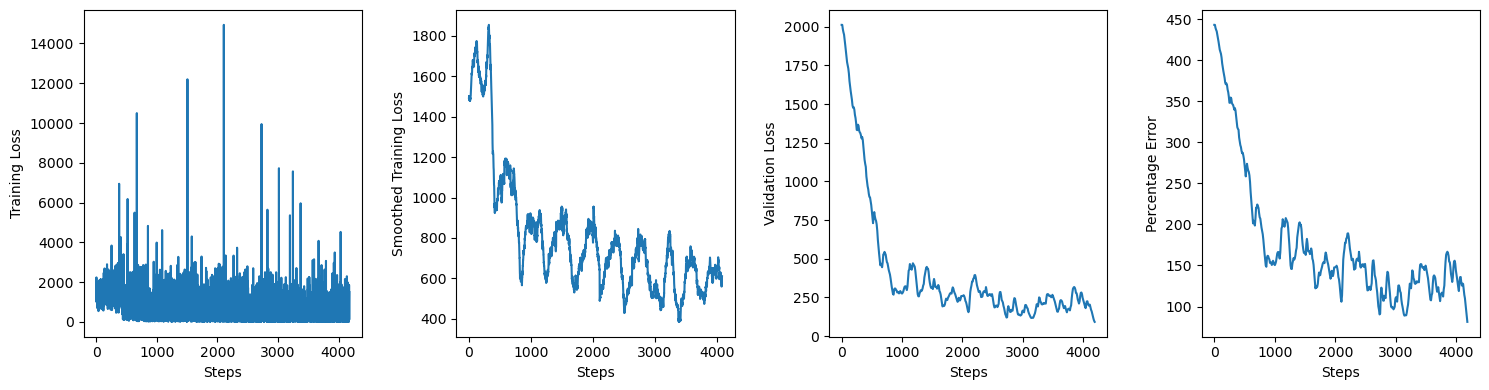

In [19]:
training_loss_log_np = [loss.detach().numpy() for loss in training_loss_log]

# ty chatgpt for this ez function :)
def moving_average(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

window_size = 100
smoothed_training_loss = moving_average(training_loss_log_np, window_size)

averaged_training_loss = [np.mean(training_loss_log_np[i:i+10]) for i in range(0, len(training_loss_log_np), 10)]

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
_ = axs[0].plot(np.arange(len(training_loss_log_np)), training_loss_log_np)
_ = axs[0].set_xlabel('Steps')
_ = axs[0].set_ylabel('Training Loss')
_ = axs[1].plot(np.arange(len(smoothed_training_loss)), smoothed_training_loss)
_ = axs[1].set_xlabel('Steps')
_ = axs[1].set_ylabel('Smoothed Training Loss')
_ = axs[2].plot(np.arange(len(evaluation_loss_log)) * check_interval, evaluation_loss_log)
_ = axs[2].set_xlabel('Steps')
_ = axs[2].set_ylabel('Validation Loss')
_ = axs[3].plot(np.arange(len(percentage_error_log)) * check_interval, percentage_error_log)
_ = axs[3].set_xlabel('Steps')
_ = axs[3].set_ylabel('Percentage Error')

_ = fig.tight_layout(h_pad=2, w_pad=2)

print("Last training loss: ", training_loss_log_np[-1])
print("Last evaluation loss: ", evaluation_loss_log[-1])
print("Last percentage error: ", percentage_error_log[-1])

plt.show()

### Optimise the parameters using Grid Search using the optuma library


In [20]:
import itertools

# Define the hyperparameter grid
param_grid = {
    'p_drop': [0.1, 0.3, 0.5, 0.7],
    'bidirectional': [True, False],
    'lr': [0.0001, 0.001, 0.01],
    'epochs': [10, 20, 50],
    'train_ratio': [0.6, 0.7, 0.8],
    'lookback': [10, 20, 30, 40, 50]
}

# Generate all combinations of hyperparameters
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


In [21]:
import optuna

In [22]:
def objective(trial):
    # Suggest values for the hyperparameters
    p_drop = trial.suggest_float('p_drop', 0.1, 0.7)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    epochs = trial.suggest_int('epochs', 10, 50)
    train_ratio = trial.suggest_float('train_ratio', 0.6, 0.8)
    lookback = trial.suggest_int('lookback', 10, 50)  # Updated with lookback
    
    # Create model and optimizer with suggested hyperparameters
    model = PhytoPredictor(input_size_phyto, lstm_hidden_size, input_size_abio, ffnn_hidden_size, output_size, p_drop, bidirectional)
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Train the model (this is your train_phytopredictor function)
    model, training_loss_log, evaluation_loss_log, percentage_error_log = train_phytopredictor(
        model, optimizer, data, trial_name, abio_columns, group_labels, shuffled_rows,
        random_seed, train_ratio, minimum_lookback, lookback, loss_metric, epochs, check_interval
    )
    
    # Evaluate the model
    evaluation_loss = evaluation_loss_log[-1]  # Assuming the last value is the evaluation loss
    
    return evaluation_loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(best_params)


In [23]:
def train_and_evaluate(params):
    # Create model and optimizer with the given hyperparameters
    model = PhytoPredictor(input_size_phyto, lstm_hidden_size, input_size_abio, 
                           ffnn_hidden_size, output_size, params['p_drop'], 
                           params['bidirectional'])
    optimizer = Adam(model.parameters(), lr=params['lr'])
    
    # Train the model
    model, training_loss_log, evaluation_loss_log, percentage_error_log = train_phytopredictor(
        model, optimizer, data, trial_name, abio_columns, group_labels, shuffled_rows,
        random_seed, params['train_ratio'], minimum_lookback, params['lookback'], 
        loss_metric, params['epochs'], check_interval
    )
    
    # Evaluate the model
    evaluation_loss = evaluation_loss_log[-1]  # Assuming the last value is the evaluation loss
    
    return evaluation_loss

# Initialize variables to store the best hyperparameters and the corresponding loss
best_params = None
best_loss = float('inf')

# Iterate over all combinations of hyperparameters
for params in combinations:
    print(f"Testing combination: {params}")
    evaluation_loss = train_and_evaluate(params)
    
    if evaluation_loss < best_loss:
        best_loss = evaluation_loss
        best_params = params

print("Best hyperparameters found:")
print(best_params)
print(f"Validation Loss: {best_loss}")


Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.6, 'lookback': 10}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/3580 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.6, 'lookback': 20}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/3580 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.6, 'lookback': 30}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/3580 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.6, 'lookback': 40}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/3580 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.6, 'lookback': 50}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/3580 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.7, 'lookback': 10}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4180 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.7, 'lookback': 20}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4180 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.7, 'lookback': 30}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4180 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.7, 'lookback': 40}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4180 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.7, 'lookback': 50}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4180 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.8, 'lookback': 10}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4780 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.8, 'lookback': 20}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4780 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.8, 'lookback': 30}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4780 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.8, 'lookback': 40}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4780 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 10, 'train_ratio': 0.8, 'lookback': 50}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/4780 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 20, 'train_ratio': 0.6, 'lookback': 10}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/7160 [00:00<?, ?it/s]

Testing combination: {'p_drop': 0.1, 'bidirectional': True, 'lr': 0.0001, 'epochs': 20, 'train_ratio': 0.6, 'lookback': 20}
PhytoPredictor(
  (history_encoder): LSTM(5, 5, bidirectional=True)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=21, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)


  0%|          | 0/7160 [00:00<?, ?it/s]

KeyboardInterrupt: 